In [58]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage.interpolation import shift
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
%matplotlib inline

In [59]:
class load_reshape(BaseEstimator,TransformerMixin):
    
    def __init__(self,Train="",Test=""):
        self.TrainFileName = Train
        self.TestFileName = Test
        self.X_train = []
        self.y_train = []
        self.X_test = []
        self.y_test = []
        
    def fit(self,*_):
        return self

    def transform(self,*_):
        T = h5py.File(self.TrainFileName)
        t = h5py.File(self.TestFileName)
        self.X_train = T['data'][:]
        self.y_train = T['label'][:]
        self.X_test= t['data'][:]
        self.y_test = t['label'][:]
        
        self.X_train = self.X_train.reshape(self.X_train.shape[0],255*255)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], 255*255)
        return self.X_train, self.y_train, self.X_test, self.y_test

In [63]:
class BalancedTrainData(BaseEstimator,TransformerMixin):
    def __init__(self,X_Train,y_Train,attributes):
        self.X_Train = X_Train
        self.y_Train = y_Train
        self.attributes = attributes
    
    def makeDataFrame(self,*_):
        Df_train = pd.DataFrame(self.X_Train)
        Df_train['label'] = self.y_Train
        return Df_train
    
    def PlotData(self,df,label,State):
        if (State == "Antes"):
            cont_label_1 = df[label].value_counts(sort=False)
            plt.figure(1)
            plt.pie((cont_label_1/cont_label_1.sum()), labels=self.attributes)
            plt.savefig('%s.pdf'%State)
        if (State == "Depois"):
            cont_label_2 = df[label].value_counts(sort=False)
            plt.figure(2)
            plt.pie((cont_label_2/cont_label_2.sum()), labels=self.attributes)
            plt.savefig('%s.pdf'%State)
        
    def shift_image(self,image,dx,dy,mode=""):
        shifted_image = shift(image, [dy, dx], cval=0,mode=mode)
        return shifted_image.reshape([-1])
        
    def Balanced(self,Df_train):
        class_ = []
        df_class = []
        class_ = Df_train.label.value_counts(sort=False)
        for i in range (len(class_)):
            df_class.append(Df_train[Df_train['label'] == i])
        maior = max(class_)
        for i in range (len(class_)):
            X_class_augmented = []
            y_class_augmented = []
            if class_[i] < maior:
                indice = df_class[i][df_class[i]['label'] == i].index.tolist()
                numberToIncrease = np.random.choice(indice, size=maior-class_[i])
                contador = 0
                for j in numberToIncrease:
                    imgToShift = (df_class[i].loc[j].drop('label', axis=0).values).reshape(255,255)
                    for dx, dy in ((50, 0), (-50, 0), (0, 50), (0, -50),(20, 0), (-25, 0), (0, 25), (0, -25)):
                        image = self.shift_image(imgToShift, dx=dx, dy=dy,mode="constant")
                        X_class_augmented.append(image)
                        y_class_augmented.append(i)
                        contador+=1;
                        if(contador==maior-class_[i]):
                            break
                    if(contador==maior-class_[i]):
                        break
                X_class_augmented = np.array(X_class_augmented)
                y_class_augmented = np.array(y_class_augmented)
                img = pd.DataFrame(X_class_augmented)
                img['label']=y_class_augmented
                df_class[i]= np.concatenate((df_class[i],img),axis=0)
              
        return df_class
        
    def fit(seft,*_):
        return self
    
    def transform(self,*_):
        Df_Train = self.makeDataFrame()
        self.PlotData(Df_Train,"label","Antes")
        Df_Train = np.concatenate([d for d in self.Balanced(Df_Train)])
        Df_Train = pd.DataFrame(Df_Train)
        label= Df_Train.columns[-1]
        self.PlotData(Df_Train,label,"Depois")
        print(Df_Train.shape)
        X_Train,y_Train = Df_Train.drop(columns=label).values, Df_Train[label].values
        return X_Train,y_Train      

In [61]:
def save_h5(h5_filename, data, label, data_dtype='float64', label_dtype='int64'):
        
        if os.path.isfile(h5_filename):
            raise ValueError("O arquivo '{}' já existe e não pode "
                             "ser apagado.".format(h5_filename))
        
        h5_fout = h5py.File(h5_filename)
        h5_fout.create_dataset('data', data=data, compression='gzip', compression_opts=4,dtype=data_dtype)
        h5_fout.create_dataset('label', data=label, compression='gzip', compression_opts=1,dtype=label_dtype)
        h5_fout.close()
        print("Arquivo salvo com sucesso.\n Acessa a sua Pasta")

#### É préciso carregar primeiramente as imagens da base de dados antes de aplicar esse metodo para balancear os dados de Treinamento e aplicar no seguinte os modelos preditivos.

(1584, 65026)


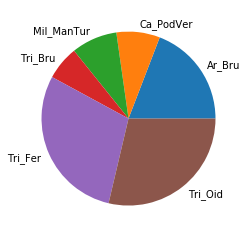

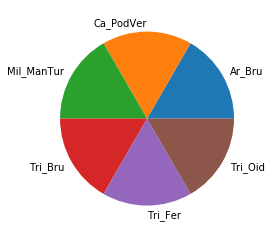

In [64]:
# Definindo os labels da pasta das imagens
attributes = ["Ar_Bru","Ca_PodVer","Mil_ManTur","Tri_Bru","Tri_Fer","Tri_Oid"]

# Carregar na memoria os DataSet
Dados = load_reshape("TrSet1-3","TeSet1-3")

#Iniciar o carregamento dos dados de Treinamento e de Test
X_Train,y_Train,X_test,y_test = Dados.transform()

# Balancear a base de Treinamento
Bal = BalancedTrainData(X_Train,y_Train,attributes)
X_Train , y_Train = Bal.transform()

# #Salvar os Dados de Treinamento aumentado
# save_h5("TrSetIncr",X_Train,y_Train)

In [37]:
X_Train.shape

(1584, 65025)